# Maternal Health Risk Assessment: A Comprehensive Model of Predictive Factors



#### Introduction:


According to the World Health Organization (WHO), maternal health can be defined as “the health of women during pregnancy, childbirth and the postnatal period. Each stage should be a positive experience, ensuring women and their babies reach their full potential for health and well-being” (WHO). The commitment to improving maternal health is not only a priority for organizations like WHO but also a central goal in the post-2015 framework for sustainable development, highlighting its enduring significance in shaping global progress.  This commitment is intricately linked to the broader context of reducing inequality, thereby promoting social justice. By addressing disparities in the quality and outcomes of care from country to country, especially in third world countries that have higher maternal health risks, there is a dedication to ensuring fair and equal opportunities for all women, irrespective of their background or geographical location.

In essence, organizations like WHO who see maternal health as key priority translates into contributing to the effort of reducing maternal health risks by, for example, “increasing research evidence, providing evidence-based clinical and programmatic guidance, setting global standards, and providing technical support to Member States on developing and implementing effective policy and programmes” (WHO). This is why recognizing the gravity of this issue is a palpable urgency to employ innovative approaches for mitigation. A potential avenue of impactful intervention lies in the development of a predictive model. This model holds the potential to discern high-risk patients among pregnant women, thereby empowering healthcare providers to allocate resources to enhance the likelihood of successful outcomes for both mothers and their newborns. 

In this report we will answer the question: Can we determine, with precision, whether a pregnant woman faces low, medium, or high maternal health risk based on key variables such as age, systolic blood pressure, diastolic blood pressure, blood glucose, body temperature, and heart rate? To answer this question, this report uses as its foundation a dataset gathered from 1013 pregnant women. This dataset represents a diverse cross-section, sourced from hospitals, clinics, and maternal health care centers embedded in the rural landscapes of Bangladesh. Each data point encapsulates the variables of interest, forming the basis for our robust predictive model. The dataset contains overall 7 columns for: age, systolic blood pressure, diastolic blood pressure, blood glucose (BS), body temperature, heart rate, and the risk classification. Age is given in years, systolic and diastolic blood pressure in mmHg, blood glucose in mmol/L, body temperature in degrees Fahrenheit, heart rate in bpm, and risk level as a categorical variables for three classifications: low risk, medium risk, and high risk. 


#### Step 1: Loading dataset from the web
First, we need to read the data from the dataset into R. Here we use `head()` to show the first 6 lines of the data and give a brief look of the data. We name it as `maternal_original_data`.

In [1]:
## reading the data into R
temp <- tempfile()
download.file("https://archive.ics.uci.edu/static/public/863/maternal+health+risk.zip",temp)
maternal_original_data <- read.csv(unzip(temp, "Maternal Health Risk Data Set.csv"))
unlink(temp)
head(maternal_original_data)

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<chr>
1,25,130,80,15.00,98,86,high risk
2,35,140,90,13.00,98,70,high risk
3,29,90,70,8.00,100,80,high risk
4,30,140,85,7.00,98,70,high risk
5,35,120,60,6.10,98,76,low risk
6,23,140,80,7.01,98,70,high risk


Before we tidy up the data, we need to check if there is N/A value in the dataset. If so, it could make our analysis biased or even affect the model performance. Let's check!

In [2]:
# no NA value within the data
has_na <- any(is.na(maternal_original_data))
has_na

[1] FALSE

Perfect! We don't need to worry about N/A value issue. Now we can move on...

### Summary of the Original Data Before Wrangling

By looking at `marternal_original_data`, we provide interpretations of each column:
- **Age**: Age in years
- **SystolicBP**: Systolic blood pressure(measures the pressure in arteries when heart beats in mmHg)
- **DiastolicBP**: Diastolic blood pressure(measure the pressure in arteries when heart rests between beats in mmHg)
- **BS**: Blood Glucose Level(in terms of a molar concentration in mmol/L)
- **BodyTemp**: Body temperature measured in Fahrenheit 
- **HearRate**: Heart rate(normal resting heart rate in bpm)
- **RiskLevel**: Predicted risk intensity level of maternal health during pregnancy considering all the prior attributes)

Other information of the original data that we want to mention is:

- There are 1013 subjects within the whole data set.


In [3]:
## loading the packages
library(tidyverse)
library(dplyr)
library(repr)
library(tidymodels)
library(rvest)
library(stringr)
install.packages("cowplot")
library(cowplot)
install.packages("kknn")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

#### Step 2: Wrangling and cleaning

Since Celcius is a more common temperature unit to us, we decide to transfer Fahrenheit scale to Celsius scale.

In [4]:
## Adding the Celcius column for interpretation purposes
maternal_with_celcius <- maternal_original_data |> 
                         mutate(Celcius = (BodyTemp - 32) * 5/9 ) 
head(maternal_with_celcius)

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel,Celcius
,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<chr>,<dbl>
1,25,130,80,15.00,98,86,high risk,36.66667
2,35,140,90,13.00,98,70,high risk,36.66667
3,29,90,70,8.00,100,80,high risk,37.77778
4,30,140,85,7.00,98,70,high risk,36.66667
5,35,120,60,6.10,98,76,low risk,36.66667
6,23,140,80,7.01,98,70,high risk,36.66667


A good dataset should always include readable variable names, so we rename our variables for each column. 

In [5]:
## Rename the columns 
names(maternal_with_celcius) <- c("Age", 
                                  "Systolic_Blood_Pressure", 
                                  "Diastolic_Blood_Pressure", 
                                  "Blood_Glucose", #mmol/L	
                                  "Farenheit",
                                  "Heart_Beat", #bpm
                                  "Risk_Level",
                                  "Body_Temp_Celcius")
maternal_new_name <- maternal_with_celcius
# Removing farenheit
maternal_new_name <- select(maternal_new_name, 
                            Age, 
                            Systolic_Blood_Pressure, 
                            Diastolic_Blood_Pressure,
                            Blood_Glucose,
                            Heart_Beat,
                            Risk_Level,
                            Body_Temp_Celcius)
head(maternal_new_name)

,Age,Systolic_Blood_Pressure,Diastolic_Blood_Pressure,Blood_Glucose,Heart_Beat,Risk_Level,Body_Temp_Celcius
,<int>,<int>,<int>,<dbl>,<int>,<chr>,<dbl>
1,25,130,80,15.00,86,high risk,36.66667
2,35,140,90,13.00,70,high risk,36.66667
3,29,90,70,8.00,80,high risk,37.77778
4,30,140,85,7.00,70,high risk,36.66667
5,35,120,60,6.10,76,low risk,36.66667
6,23,140,80,7.01,70,high risk,36.66667


First, we added the Celsius column to help with understanding of the data later, and we also changed the column names so they are easier to identify. Then we removed the farenheit column because it's unnecessary now there's a Celsius column.

We classify based on risk levels, so `Risk_Level` will be a factor. As we have 6 predictors, we want to choose our predictors for the model wisely and avoid irrelevant variables as much as possible. Hence, using histogram to see the numbers of each predictors among risk levels is helpful.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


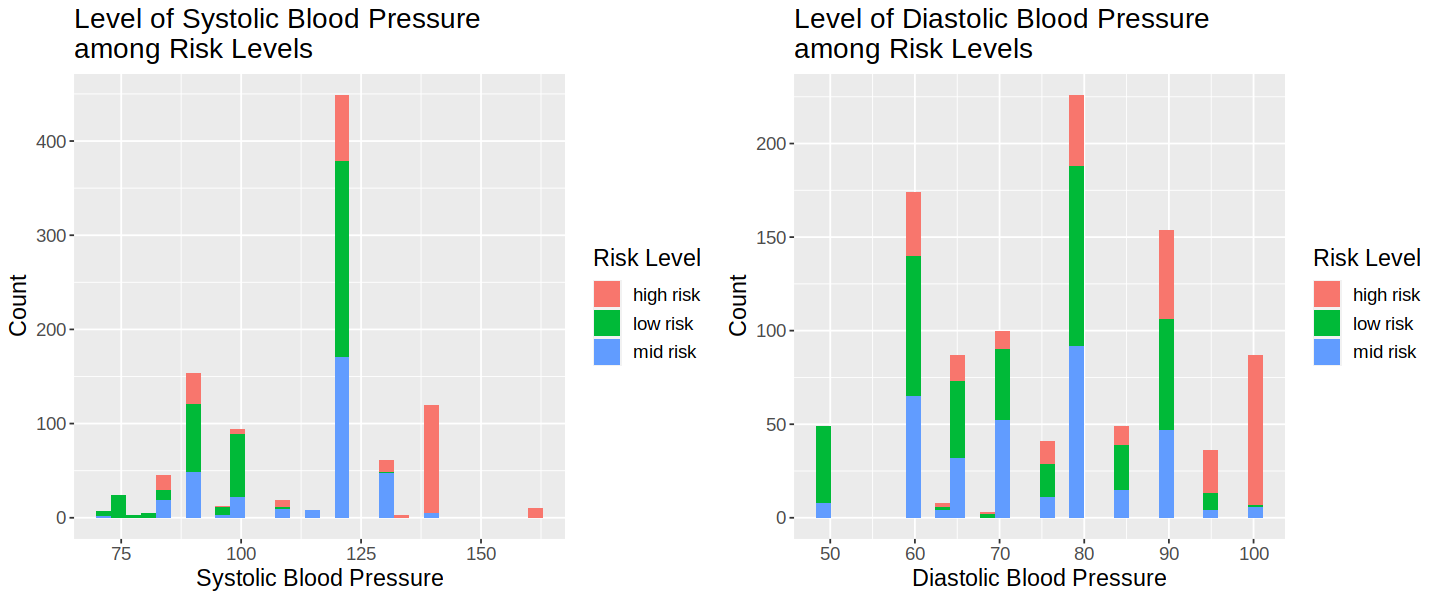

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


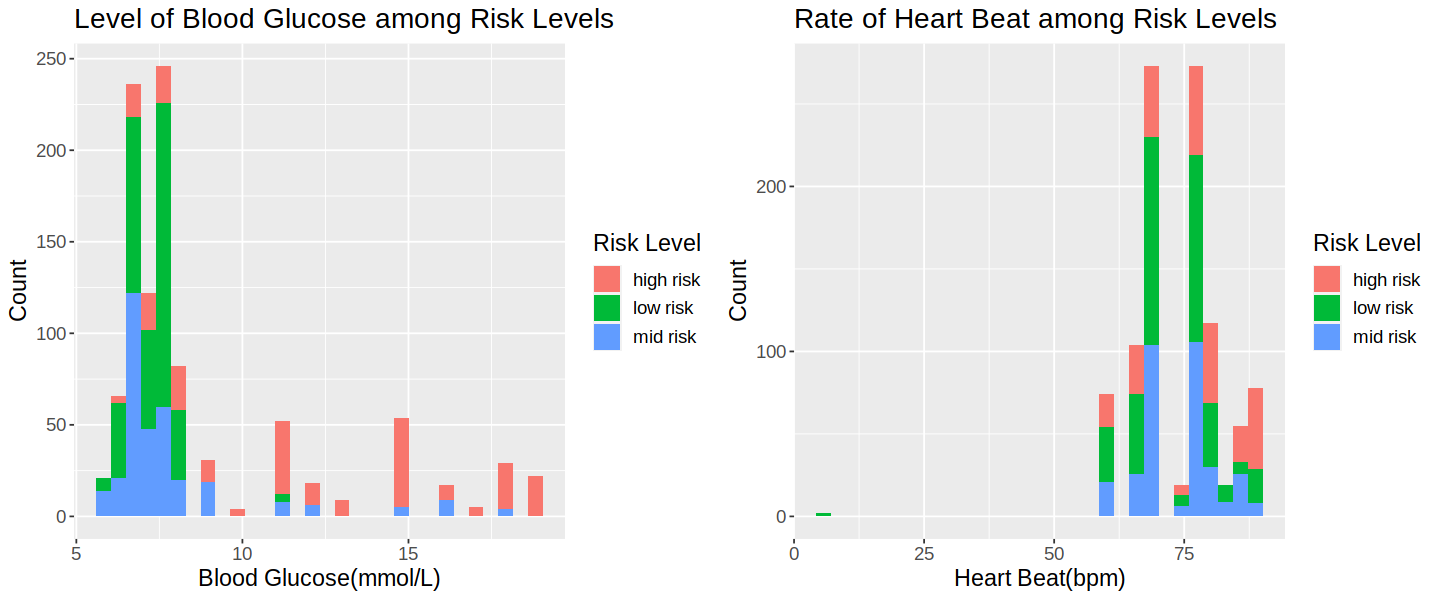

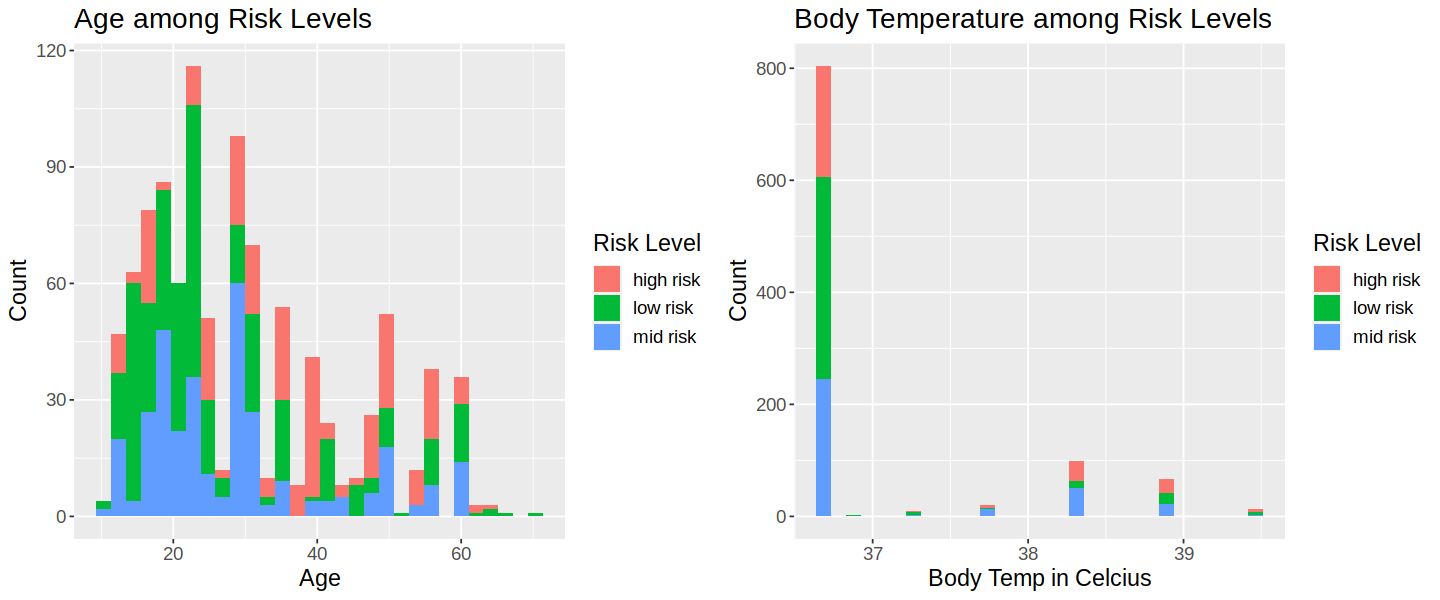

In [25]:
options(repr.plot.width = 12, repr.plot.height = 5) 
# initial visualization
systolic_histogram <- ggplot(maternal_new_name, aes(x = Systolic_Blood_Pressure, fill = as_factor(Risk_Level))) +
                     geom_histogram(alpha = 0.5, position = "identity") +
                     stat_bin(bins = 30) +
                     labs(x = "Systolic Blood Pressure", fill = "Risk Level", y = "Count") +
                     ggtitle("Level of Systolic Blood Pressure \namong Risk Levels") +
                     theme(text = element_text(size = 14))

diastolic_histogram <- ggplot(maternal_new_name, aes(x = Diastolic_Blood_Pressure, fill = as_factor(Risk_Level))) +
                     geom_histogram(alpha = 0.5, position = "identity") +
                     stat_bin(bins = 30) +
                     labs(x = "Diastolic Blood Pressure", fill = "Risk Level", y = "Count") +
                     ggtitle("Level of Diastolic Blood Pressure \namong Risk Levels") +
                     theme(text = element_text(size = 14))

bs_histogram <- ggplot(maternal_new_name, aes(x = Blood_Glucose, fill = as_factor(Risk_Level))) +
                     geom_histogram(alpha = 0.5, position = "identity") +
                     stat_bin(bins = 30) +
                     labs(x = "Blood Glucose(mmol/L)", fill = "Risk Level", y = "Count") +
                     ggtitle("Level of Blood Glucose among Risk Levels") +
                     theme(text = element_text(size = 14))

heart_beat_histogram <- ggplot(maternal_new_name, aes(x = Heart_Beat, fill = as_factor(Risk_Level))) +
                     geom_histogram(alpha = 0.5, position = "identity") +
                     stat_bin(bins = 30) +
                     labs(x = "Heart Beat(bpm)", fill = "Risk Level", y = "Count") +
                     ggtitle("Rate of Heart Beat among Risk Levels") +
                     theme(text = element_text(size = 14))

age_histogram <- ggplot(maternal_new_name, aes(x = Age, fill = as_factor(Risk_Level))) +
                     geom_histogram(alpha = 0.5, position = "identity") +
                     stat_bin(bins = 30) +
                     labs(x = "Age", fill = "Risk Level", y = "Count") +
                     ggtitle("Age among Risk Levels") +
                     theme(text = element_text(size = 14))

celsius_histogram <- ggplot(maternal_new_name, aes(x = Body_Temp_Celcius, fill = as_factor(Risk_Level))) +
                     geom_histogram(alpha = 0.5, position = "identity") +
                     stat_bin(bins = 30) +
                     labs(x = "Body Temp in Celcius", fill = "Risk Level", y = "Count") +
                     ggtitle("Body Temperature among Risk Levels") +
                     theme(text = element_text(size = 14))

plot_grid(systolic_histogram, diastolic_histogram, nrow = 1)
plot_grid(bs_histogram, heart_beat_histogram, ncol = 2)
plot_grid(age_histogram, celsius_histogram, ncol = 2)

From the above visualizations, we can conclude a few things:
1. Temperature is not worth using as a predictor because the distribution of different risk levels remain about the same for those small changes within the temperature. The overall temperature also remained within the normal range around 36 to 39 degrees. It's also extremely right skewed meaning majority of the women had a normal temperature in this data set, therefore, it will be misleading to use temperature as a predictor for the prediction. 
2. Blood glucose, age and systolic and diastolic blood pressure are 4 predictors that visually seem especially important to the prediction because as both four variables increase, high risk level starts to appear more often. 
3. Although heart beat doesn't show as clear of a trend as the other predictors, there still seem to have a connection between heart beat and risk level because the risk level does increase as heart beat increases.
In conclusion, after examining the initial visualizations, we determine to use **age**, **systolic blood pressure**, **diastolic blood pressure**, **blood glucose**, and **heart beat** as predictors.

We ignore `Body_Temp_Celcius` and make `Risk_Level` as factor for classification. The final dataset is named as `maternal_final`.

In [7]:
## Delete body temperature column
maternal_final <- maternal_new_name |>
                  select(Age,Systolic_Blood_Pressure,Diastolic_Blood_Pressure,
                         Blood_Glucose, Heart_Beat, Risk_Level) |>
                  mutate(Risk_Level = as_factor(Risk_Level))
head(maternal_final)

,Age,Systolic_Blood_Pressure,Diastolic_Blood_Pressure,Blood_Glucose,Heart_Beat,Risk_Level
,<int>,<int>,<int>,<dbl>,<int>,<fct>
1,25,130,80,15.00,86,high risk
2,35,140,90,13.00,70,high risk
3,29,90,70,8.00,80,high risk
4,30,140,85,7.00,70,high risk
5,35,120,60,6.10,76,low risk
6,23,140,80,7.01,70,high risk


#### Overall data selection and analysis:
In alignment with our data analysis, our decision to exclude temperature as a significant variable in determining maternal health risk is supported by a complementary study conducted by Marzia Ahmed and Mohammod Abul Kashem from the Department of Software Engineering at Daffodil International University and the Department of Computer Science and Engineering at Dhaka University of Science and Technology, respectively. Their work utilized a significance ranking system to assess the influence of the factors (age, systolic blood pressure, diastolic blood pressure, blood glucose (BS), body temperature, and heart rate).

According to their findings, blood sugar (BS) emerged as the most influential risk factor in pregnancy, “Especially the mother affected by diabetes is considerably more responsible about three times higher than Blood Pressure and other factors” (Ahmed & Kashem, 2020). Notably, their analysis, rooted in the context of decision trees and entropy, indicated that temperature had a comparatively lower influence over the risk classification. 


After cleaning the data by getting rid of unnecessary columns, we will set seeds to ensure randomness and split the data to prepare with the classification process. We split the data into 75% of training data and 25% testing data. 

In [8]:
## Setting seed and splitting data into trianing set and testing set 
set.seed(10)
maternal_split <- initial_split(maternal_final, prop = 0.75, strata = Risk_Level)
maternal_train <- training(maternal_split)
maternal_test <- testing(maternal_split) 
glimpse(maternal_train)
glimpse(maternal_test)

Rows: 760
Columns: 6
$ Age                      <int> 30, 23, 35, 50, 40, 48, 23, 34, 50, 42, 32, 3…
$ Systolic_Blood_Pressure  <int> 140, 140, 85, 140, 140, 140, 140, 85, 140, 14…
$ Diastolic_Blood_Pressure <int> 85, 80, 60, 90, 100, 90, 90, 60, 90, 100, 100…
$ Blood_Glucose            <dbl> 7.00, 7.01, 11.00, 15.00, 18.00, 15.00, 6.80,…
$ Heart_Beat               <int> 70, 70, 86, 90, 90, 90, 70, 86, 90, 90, 78, 8…
$ Risk_Level               <fct> high risk, high risk, high risk, high risk, h…
Rows: 254
Columns: 6
$ Age                      <int> 25, 35, 29, 35, 42, 19, 25, 10, 21, 20, 22, 2…
$ Systolic_Blood_Pressure  <int> 130, 140, 90, 120, 130, 120, 140, 70, 120, 10…
$ Diastolic_Blood_Pressure <int> 80, 90, 70, 60, 80, 80, 100, 50, 80, 90, 90, …
$ Blood_Glucose            <dbl> 15.00, 13.00, 8.00, 6.10, 18.00, 7.00, 7.01, …
$ Heart_Beat               <int> 86, 70, 80, 76, 70, 70, 80, 70, 76, 88, 82, 8…
$ Risk_Level               <fct> high risk, high risk, high risk, low risk, hi

#### Step 4: Finding optimal k

To find the optimal k, we first set up a recipe with training data. The predictors should be standardized as we want to avoid outliers or large scales affecting the model performance. 

In [10]:
# recipe for training data
maternal_recipe <- recipe(Risk_Level ~.,
                          data = maternal_train) |>
                   step_scale(all_predictors()) |>
                   step_center(all_predictors())
maternal_recipe

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          5

Operations:

Scaling for all_predictors()
Centering for all_predictors()

Next, we are going to do cross-validation to help us evaluate the classifier. Since we do not know the optimal k initially,  we will use `tune()` in this case.

In [11]:
# model for training data 
maternal_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
                 set_engine("kknn") |>
                 set_mode("classification")
maternal_spec

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [12]:
# creating v folds for traning data 
maternal_vfold_10 <- vfold_cv(maternal_train, v = 10, strata = Risk_Level)

# data frame that contains sequence of K values
maternal_k_vals <- tibble(neighbors = seq(from = 1, to = 70, by = 1))

We starts finding the optimal K by creating a recipe with all the necessary predictors, a model for classification. Next, we decide to first try 10 folds because we have a relatively big size of data. We kept the range of k values in a smaller range relative to the size of the data, as k could be smaller than we thought.

In [13]:
# fitting the model
maternal_first_workflow <- workflow () |>
                           add_recipe(maternal_recipe) |>
                           add_model(maternal_spec) |>
                           tune_grid(resamples = maternal_vfold_10, grid = maternal_k_vals) |>
                           collect_metrics()
                        
head(maternal_first_workflow)

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.8078595,10,0.01843905,Preprocessor1_Model01
1,roc_auc,hand_till,0.8583550,10,0.01298562,Preprocessor1_Model01
2,accuracy,multiclass,0.7985594,10,0.02015608,Preprocessor1_Model02
2,roc_auc,hand_till,0.8586280,10,0.01336624,Preprocessor1_Model02
3,accuracy,multiclass,0.6959341,10,0.01871669,Preprocessor1_Model03
3,roc_auc,hand_till,0.8497369,10,0.01431789,Preprocessor1_Model03


With `maternal_first_workflow`, we are able to compute accuracies about how the model is fitting. Then we can plot a graph on k neighbors vs accuracy estimate.

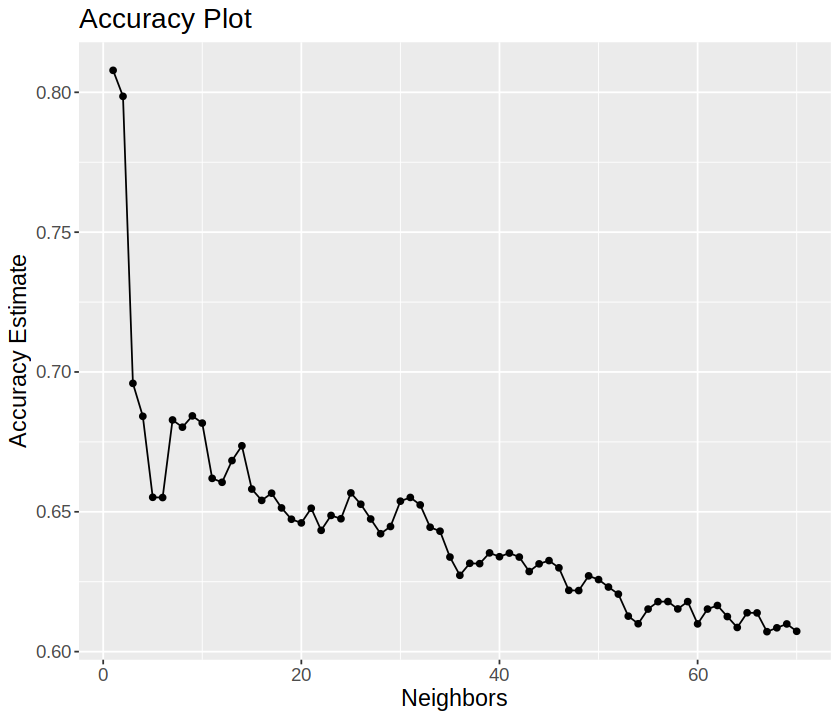

In [15]:
# getting only the accuracies
options(repr.plot.width = 7, repr.plot.height = 6) 
accuracies <- maternal_first_workflow |>
             filter(.metric == "accuracy")

# accuracy plot
accuracy_plot <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
                geom_point() +
                geom_line() +
                labs(x = "Neighbors", y = "Accuracy Estimate") +
                ggtitle("Accuracy Plot") +
                theme(text = element_text(size = 14))
accuracy_plot

From this plot, it's clear that the amount of neighbor we need will be relatively small, therefore we made a second plot with less neighbors to get a better read of the amount of the k we need.

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.8078595,10,0.01843905,Preprocessor1_Model01
1,roc_auc,hand_till,0.8583550,10,0.01298562,Preprocessor1_Model01
2,accuracy,multiclass,0.7985594,10,0.02015608,Preprocessor1_Model02
2,roc_auc,hand_till,0.8586280,10,0.01336624,Preprocessor1_Model02
3,accuracy,multiclass,0.6959341,10,0.01871669,Preprocessor1_Model03
3,roc_auc,hand_till,0.8497369,10,0.01431789,Preprocessor1_Model03


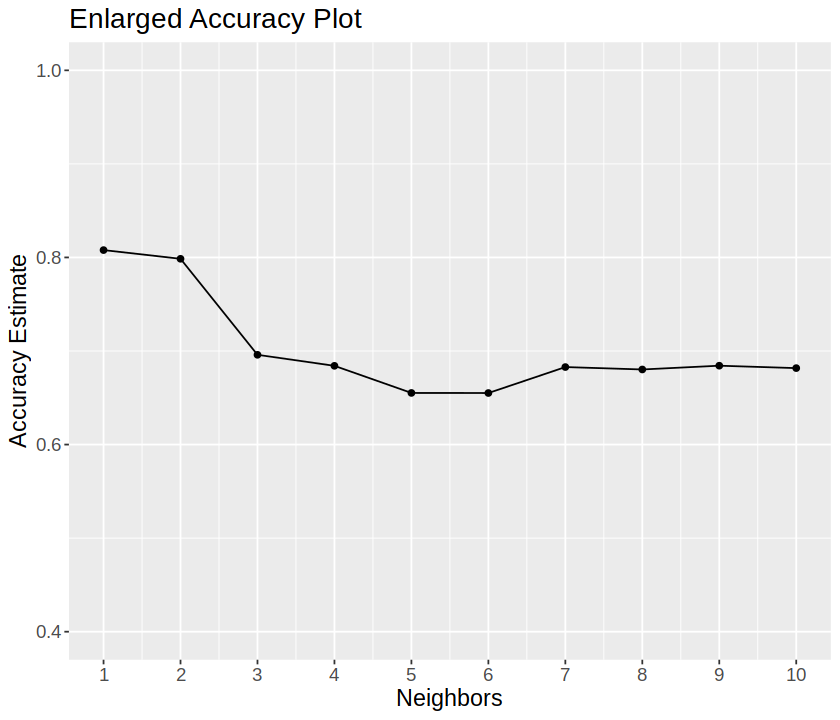

In [16]:
# new k values
maternal_k <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

# fitting the newer model
maternal_new_workflow <- workflow () |>
                           add_recipe(maternal_recipe) |>
                           add_model(maternal_spec) |>
                           tune_grid(resamples = maternal_vfold_10, grid = maternal_k) |>
                           collect_metrics()
head(maternal_new_workflow)

# getting only the accuracies
accuracy <- maternal_new_workflow |>
             filter(.metric == "accuracy")

# accuracy plot
options(repr.plot.width = 7, repr.plot.height = 6) 
accuracy_plot_2 <- ggplot(accuracy, aes(x = neighbors, y = mean)) +
                geom_point() +
                geom_line() +
                labs(x = "Neighbors", y = "Accuracy Estimate") +
                scale_x_continuous(breaks = seq(0, 14, by = 1)) +
                scale_y_continuous(limits = c(0.4, 1.0)) +
                ggtitle("Enlarged Accuracy Plot") +
                theme(text = element_text(size = 14))
accuracy_plot_2

After tuning the grid, filtering out the accuracy and plotting out the accuracy plot, we've determined that k = 1 would provide the highest accuracy, which is around 81% when we split our training data into 10 folds. It also shows that if we increase the amount of k-neighbors in our model, the accuracy will decrease. However, using k = 1 may cause a overfitting problem. It is suggesting there could be a simpler model and some irrelevant variables affecting the classification.  

#### Step 5: Final model

After prediction using training data, we need to test if our predictions is good enough. First things first, we need to set up a workflow and the previous recipe we created is still usable.

In [17]:
# new model
maternal_final_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 1) |>
                       set_engine("kknn") |>
                       set_mode("classification")

# new workflow
maternal_final_workflow <- workflow() |>
                           add_recipe(maternal_recipe) |>
                           add_model(maternal_final_spec) |>
                           fit(data = maternal_train)
maternal_final_workflow

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(1,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.1565789
Best kernel: rectangular
Best k: 1

With our new k value, we created a new model and fit it again for the final workflow to use in predictions of the test data set.

In [18]:
# predicting testing data
maternal_predict <- predict(maternal_final_workflow, maternal_test) |>
                    bind_cols(maternal_test)
head(maternal_predict)

.pred_class,Age,Systolic_Blood_Pressure,Diastolic_Blood_Pressure,Blood_Glucose,Heart_Beat,Risk_Level
<fct>,<int>,<int>,<int>,<dbl>,<int>,<fct>
high risk,25,130,80,15.0,86,high risk
high risk,35,140,90,13.0,70,high risk
high risk,29,90,70,8.0,80,high risk
low risk,35,120,60,6.1,76,low risk
high risk,42,130,80,18.0,70,high risk
low risk,19,120,80,7.0,70,mid risk


We can assess our classifier’s performance now by checking the accuracy. Here the accuracy is about 79.13%, which is near the accuracy with training data.

In [19]:
# assessing classifier's performance
maternal_metrics <- maternal_predict |>
                    metrics(truth = Risk_Level, estimate = .pred_class) |>
                    filter(.metric == "accuracy")
maternal_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.7913386


In specific, we can look at the confusion matrix for the risk level. It will show the number of observations that is correctly or falsely predicted.

In [20]:
# producing the confusion matrix
maternal_matrix <- maternal_predict |>
                   conf_mat(truth = Risk_Level, estimate = .pred_class)
maternal_matrix

           Truth
Prediction  high risk low risk mid risk
  high risk        62        5        5
  low risk          3       81       21
  mid risk          3       16       58

From the matrix table above, we can see that 62 observations were correctly predicted as high risk, 81 observations were correctly predicted as low risk, and 58 observations were correctly predicted as mid risk. The classifier also made some mistakes. There are 10 observations predicted as high risk but 5 of them are truly low risk, while the other 5 are truly mid risk. 24 observations are predicted as low risk, but 3 of them are truly high risk, the other 21 are truly mid risk. It also classified 19 observations as mid risk but 3 of them are truly high risk, and 16 of them are truly low risk. 

Furthermore, from the accuracy plot, we can expect about 81% accuracy when we use k = 1. The matrix shows that we have an accuracy at around 79.13%; we found that value by doing (62+81+58)/(62+3+3+5+81+16+5+21+58) which is the number of correct predictions over total number of predictions. We do have a slightly lower accuracy than what we've expected from the optimal k plot, not by a lot though. 

Using the formula for precision = true positive / (true positive + false positive), our model has a precision for each risk level as follows:
- High Risk: 62/(5+5+62) = 0.86
- Low Risk: 81/(3+21+81) = 0.77
- Mid Risk: 58/(3+16+58) = 0.75

As for recall = true positive / (true positive + false negative), we have:

- High Risk: 62/(62+3+3) = 0.91
- Low Risk: 81/(81+5+16) = 0.79
- Mid Risk: 58/(58+21+5) = 0.69

This data shows that our classifier does a particular bad job at identifying mid risk compared low and high risk level in terms of both precision and recall, meaning that we can't really trust it on identifying neither the positive as positive or those it identifies as positive to be positive. However, our model does a decent job identifying high risk which is ideal, because in this situation, we need to prioritize identifying those that are more prone to have maternal birth issues in order to prevent further medical troubles. It's also ideal that high risk has a recall of 0.91 because in this context, we would want to identify mothers that are actually high risk rather having a high precision. 

#### Step 6: Visualization of the Analysis

Finally, to find out the trends of how predictors related to each other based on risk level, we will choose a few predictors that have more significant data observed from the histograms and create some scatter plots. 

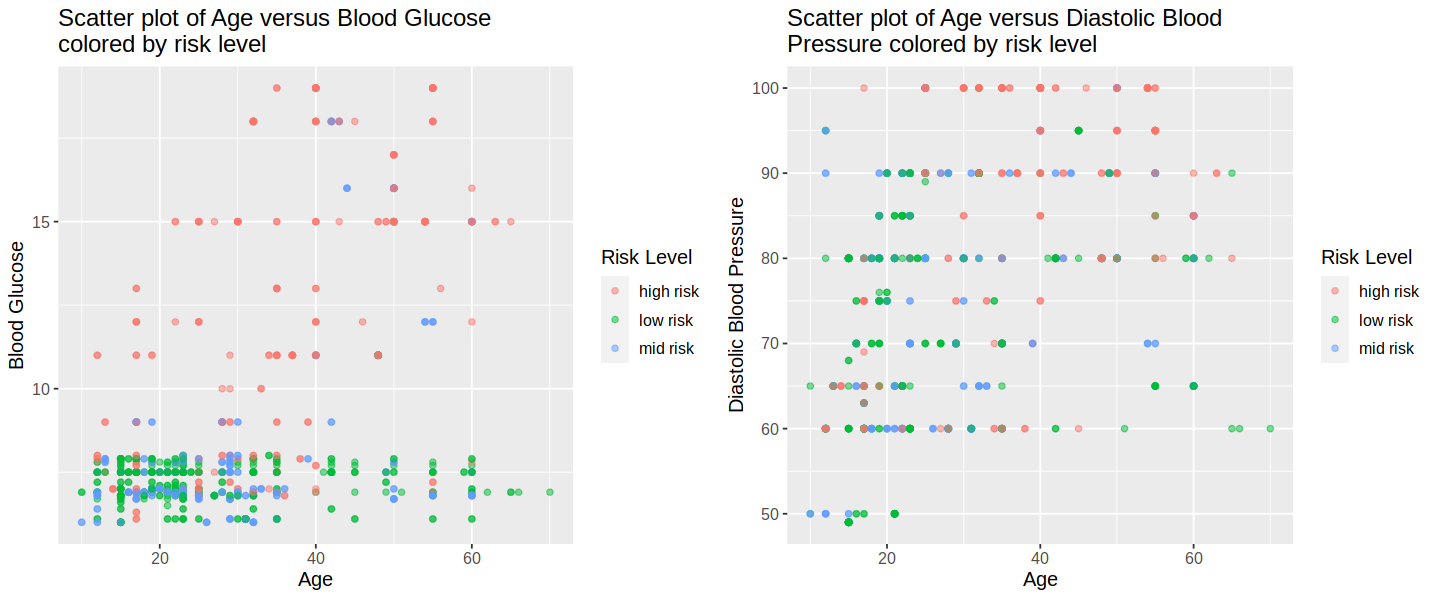

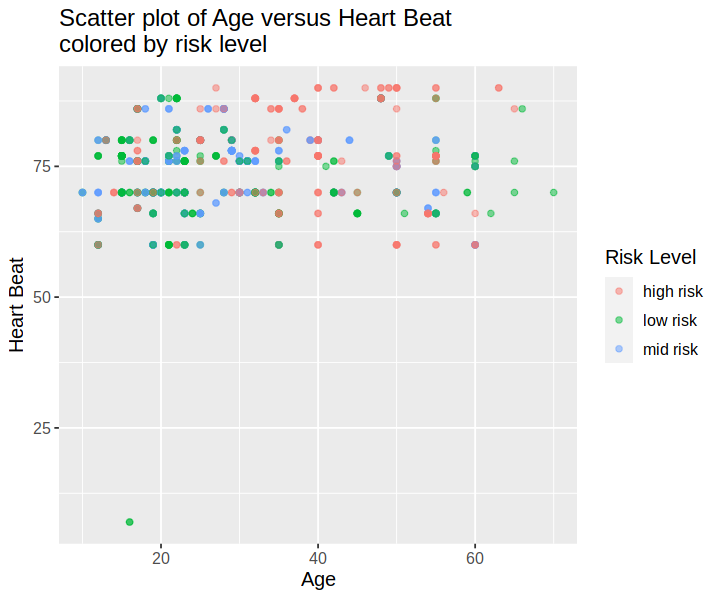

In [24]:
options(repr.plot.width = 12, repr.plot.height = 5) 
plot_age_vs_blood_glucose <- ggplot(maternal_final, aes(x = Age, y = Blood_Glucose, color = Risk_Level)) +
                            geom_point(alpha = 0.5) +
                            labs(x = "Age", y = "Blood Glucose", color = "Risk Level") +
                            ggtitle("Scatter plot of Age versus Blood Glucose \ncolored by risk level") +
                            theme(text = element_text(size = 12))


plot_age_vs_diastolic_blood_pressure <- ggplot(maternal_final, aes(x = Age, y = Diastolic_Blood_Pressure, color = Risk_Level)) +
                                        geom_point(alpha = 0.5) +
                                        labs(x = "Age", y = "Diastolic Blood Pressure", color = "Risk Level") +
                                        ggtitle("Scatter plot of Age versus Diastolic Blood \nPressure colored by risk level") +
                                        theme(text = element_text(size = 12))


plot_age_vs_heart_beat <- ggplot(maternal_final, aes(x = Age, y = Heart_Beat, color = Risk_Level)) +
                          geom_point(alpha = 0.5) +
                          labs(x = "Age", y = "Heart Beat", color = "Risk Level") +
                          ggtitle("Scatter plot of Age versus Heart Beat \ncolored by risk level") +
                          theme(text = element_text(size = 12))

plot_grid(plot_age_vs_blood_glucose, plot_age_vs_diastolic_blood_pressure, nrow = 1)
options(repr.plot.width = 6, repr.plot.height = 5) 
plot_age_vs_heart_beat

We created 3 scatter plots all setting `Age` as independent variable, and three other variables, `Blood_Glucose`, `Diastolic_Blood_Pressure`, `Heart_Beat`, as dependent variables. We colored the risk level to help us understand how the classifier tend to change. We observe that the scatter points are distributed vertically and horizontally in the plots. This is because the variables are numeric. 

Let's first explore age vs. blood glucose. Among all ages, all three risk levels appear. Most women who have low blood glucose are in low risk before mid-age. High maternal health risk happens after mid-age with higher blood glucose. As age increases, the diastolic blood pressure seems to be higher and high maternal health risk happens more often. Notice that no matter young women who have low or high diastolic blood pressure, most of them maintain in low risk. The last plot is showing age vs. heart beat. It looks more severe than the previous two as there are more points colored in brown, and they are spread across various ages and different heart beats. It indicates high maternal health risk exists regardless of heart beat. However, we can still see that younger women tend to have low or middle maternal health risk, while high maternal health risk are distributed more in elder women with higher heart beat. 

Hence, in general, young women (15-30 years old) are in low maternal health risk even when they have high health indicators. The reason is that they have better physical resilience and self-healing at a younger age. As women get older (at and after 40 years old), elevated health indicators due to reduced physical functioning increase health risks. (Stefanick ML, 2016)

#### Discussion:

- Expected & Actual Findings:
  
In the beginning of this project, we expect the multifactorial nature of maternal health risks suggests that multiple variables collectively contribute to the overall risk assessment, highlighting that no single factor holds all the weight in determining risk. Variables like blood pressure, body temperature, and blood sugar levels positively impact risk assessment, with older mothers having higher maternity risk. 

After splitting our training data into 10 folds and creating our accuracy plot to evaluate our values for k, we decided to use k=1 as it yielded the highest accuracy during testing. However, this choice led to an overfitting issues within our model. The low k value emphasized individual data points too much, resulting in a model that closely mimicked the training data but struggled to generalize to new data. We believe this problem arose due to a lack of diverse/relevant predictors, limiting the model's ability to identify broader patterns. One of our predictions before starting this project was that we would find that no single variable could correctly determine the risk and we think that has stayed true.

As we delved deeper into the project, it became evident that no single factor could bear the entire weight of risk assessment due to its multifaceted nature. This understanding prompted us to include numerous variables as predictors, acknowledging the intricate layers of the problem. Our graphical analyses revealed intriguing patterns: Blood Glucose levels, when used as a risk classifier, almost certainly marked a positive classification for high risk. On the other hand, plotting Diastolic Blood Pressure against Age or Heart Beats against Age highlighted the dominant influence of female age, notably linking most "high-risk" patients to higher Age values in these plots. However when it comes to predicting low-risk and mid-risk patients the lines become a lot more blurry as it is much more difficult to predict those with many data points from both classes being populated fairly close to each other. A simple generalization would show that having a lower age value on the plots automatically gives that data point a very good chance at being low-risk. 

Since we have an overfitting problem, what we can do in the future is that utilizing forward selection method to get rid of irrelevant predictors and gain a simpler model. Then we can apply cross-validation again to find a better k value and see if the model have a higher accuracy of predicting the classification. 

- Impact of Findings:

The analysis of variables and expected risk in the maternal health dataset can significantly influence maternal healthcare, healthcare policy, and public health initiatives.
1) Understanding risk factors can help in creating health education programs promoting healthy lifestyle choices, including prenatal care, diet-related risk reduction, and general health practices among pregnant women.
2) The findings could drive further research and innovation in maternal health, focusing on developing better diagnostic tools to identify risk factors, thereby improving treatment options and health outcomes for pregnant women.

- Future Questions:
  
1) How can the insights from the predictive model be used to create personalized care plans for pregnant women, considering their individual health profiles? 
2) How can the model be integrated into the monitoring and evaluation system to identify high-risk expecting mothers and ensure frequent monitoring to enhance maternal health outcomes?

#### References Used:

Ahmed,Marzia. (2023). Maternal Health Risk. UCI Machine Learning Repository. https://doi.org/10.24432/C5DP5D.

Stefanick ML;Brunner RL;Leng X;Limacher MC;Bird CE;Garcia DO;Hogan PE;LaMonte MJ;Mackey RH;Johnson KC;LaCroix A;Robinson JG;Seguin RA;Tindle HA;Wassertheil-Smoller S; (2016, March). The relationship of cardiovascular disease to physical functioning in women surviving to age 80 and above in the Women’s Health initiative. The journals of gerontology. Series A, Biological sciences and medical sciences. https://pubmed.ncbi.nlm.nih.gov/26858324/ 